In [1]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [2]:
train_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [3]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

## Tokenizer

In [4]:
def spacy_tokenizer(doc):
    return [t.lemma_.lower() for t in nlp(doc) if \
            len(t) > 2 and \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha]

In [5]:
def preprocess_text(text):
    tokens = spacy_tokenizer(text)
    return "|".join(tokens)

In [6]:
%%time
preprocessed_train_corpus = [preprocess_text(post) for post in train_corpus.data]

CPU times: total: 3min 50s
Wall time: 3min 51s


In [7]:
print(preprocessed_train_corpus[0])
print(preprocessed_train_corpus[1])

wonder|enlighten|car|see|day|door|sport|car|look|late|early|call|bricklin|door|small|addition|bumper|separate|rest|body|know|tellme|model|engine|spec|year|production|car|history|info|funky|look|car|mail
fair|number|brave|soul|upgrade|clock|oscillator|share|experience|poll|send|brief|message|detail|experience|procedure|speed|attain|cpu|rate|speed|add|card|adapter|heat|sink|hour|usage|day|floppy|disk|functionality|floppy|especially|request|summarize|day|add|network|knowledge|base|clock|upgrade|answer|poll|thank


In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [9]:
print(len(train_data), len(val_data))

9616 1698


In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split="|", oov_token='OOV')

In [11]:
tokenizer.fit_on_texts(train_data)

In [12]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '|',
 'char_level': False,
 'oov_token': 'OOV',
 'document_count': 9616,
 'word_counts': '{"sorry": 295, "followup": 49, "email": 685, "address": 706, "try": 1770, "decide": 372, "printer": 250, "like": 3489, "hear": 846, "user": 673, "question": 1448, "thank": 1299, "xrpc": 1, "package": 562, "year": 2395, "believe": 1373, "get": 1897, "export": 163, "anybody": 355, "big": 649, "electron": 29, "noah": 6, "rob": 101, "butera": 1, "ask": 1108, "book": 861, "call": 1022, "lose": 439, "years": 8, "jesus": 682, "elizabeth": 8, "clare": 3, "prophet": 62, "know": 3850, "miss": 277, "leader": 173, "group": 1017, "church": 445, "universal": 52, "triumphant": 3, "derive": 62, "found": 48, "ballard": 4, "begin": 360, "mission": 213, "write": 1129, "memory": 453, "detail": 331, "straight": 143, "old": 865, "account": 246, "check": 577, "library": 315, "bnook": 1, "marcus": 6, "bach": 8, "eighteenth": 4, "century": 154, "frenchman": 1,

In [13]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 45379


## Vectorization

In [14]:
print(train_data[:1])

binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['sorry|followup|email|address|try|decide|printer|like|hear|user|printer|question|thank']
Vector shape: (1, 45380)
[[0. 0. 0. ... 0. 0. 0.]]


In [15]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ". join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [   3   27   32   41   96  137  142  146  373  504  617 2591]
like try question thank hear address email user decide sorry printer followup


In [16]:
tfidf_bow = tokenizer.texts_to_matrix(train_data[:1], mode='tfidf')
print(tfidf_bow, '\n')

print(f"TF-IDF scores of the first post's tokens:\n {tfidf_bow[0][present_tokens]}")

[[0. 0. 0. ... 0. 0. 0.]] 

TF-IDF scores of the first post's tokens:
 [1.67181117 2.17534187 2.46233233 2.21592895 2.78892285 3.28251394
 3.19211311 3.59685722 3.51442517 3.5513158  7.48557896 5.43787225]


In [17]:
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))

In [18]:
X_train.shape

TensorShape([9616, 45380])

In [19]:
print(train_labels)

[ 2  5  4 ... 15  6  2]


In [20]:
y_train = keras.utils.to_categorical(train_labels)

In [21]:
print(y_train.shape)
print(y_train[0])
print(f"Target/class : {train_corpus.target_names[np.argmax(y_train[0])]}")

(9616, 20)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target/class : comp.os.ms-windows.misc


In [22]:
X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

## Build model

In [23]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_UNITS = 128

tf.random.set_seed(0)

model = keras.Sequential([
    layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
    layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
    layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

In [24]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [25]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/15
76/76 [==============================] - 3s 32ms/step - loss: 2.6715 - accuracy: 0.2654 - val_loss: 2.1492 - val_accuracy: 0.4229
Epoch 2/15
76/76 [==============================] - 2s 28ms/step - loss: 1.6415 - accuracy: 0.5931 - val_loss: 1.5457 - val_accuracy: 0.5383
Epoch 3/15
76/76 [==============================] - 2s 28ms/step - loss: 1.0394 - accuracy: 0.7351 - val_loss: 1.2774 - val_accuracy: 0.6266
Epoch 4/15
76/76 [==============================] - 2s 28ms/step - loss: 0.7094 - accuracy: 0.8162 - val_loss: 1.1941 - val_accuracy: 0.6443
Epoch 5/15
76/76 [==============================] - 2s 28ms/step - loss: 0.5021 - accuracy: 0.8707 - val_loss: 1.1465 - val_accuracy: 0.6708
Epoch 6/15
76/76 [==============================] - 2s 29ms/step - loss: 0.3684 - accuracy: 0.9099 - val_loss: 1.2026 - val_accuracy: 0.6667
Epoch 7/15
76/76 [==============================] - 2s 28ms/step - loss: 0.2802 - accuracy: 0.9344 - val_loss: 1.2490 - val_accuracy: 0.6702
Epoch 8/15
76

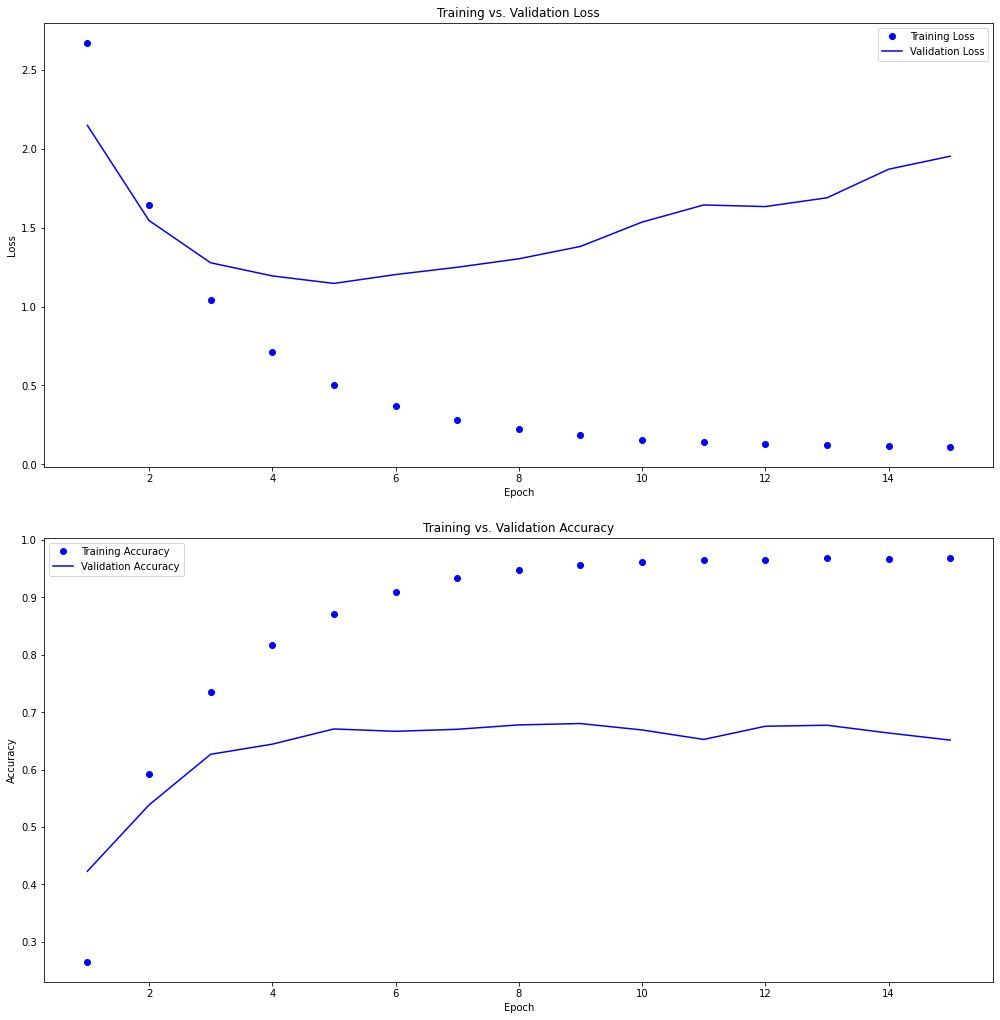

In [26]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [27]:
tf.random.set_seed(0)
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/5
76/76 [==============================] - 3s 29ms/step - loss: 2.6715 - accuracy: 0.2654 - val_loss: 2.1492 - val_accuracy: 0.4229
Epoch 2/5
76/76 [==============================] - 2s 28ms/step - loss: 1.6415 - accuracy: 0.5931 - val_loss: 1.5457 - val_accuracy: 0.5383
Epoch 3/5
76/76 [==============================] - 2s 27ms/step - loss: 1.0394 - accuracy: 0.7351 - val_loss: 1.2774 - val_accuracy: 0.6266
Epoch 4/5
76/76 [==============================] - 2s 27ms/step - loss: 0.7094 - accuracy: 0.8162 - val_loss: 1.1941 - val_accuracy: 0.6443
Epoch 5/5
76/76 [==============================] - 2s 27ms/step - loss: 0.5021 - accuracy: 0.8707 - val_loss: 1.1465 - val_accuracy: 0.6708


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               5808768   
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
Total params: 5,827,860
Trainable params: 5,827,860
Non-trainable params: 0
_________________________________________________________________


In [30]:
v = (len(tokenizer.word_index) + 1)
print(f"Size of vocabulary of columns in BoW array (v): {v}")

n = NUM_UNITS
print(f"Number of units in the first layer(n): {n} \n")

p = v * n + n
print(f"Number of params in the first layer(p) = v * n + n = {p}")

Size of vocabulary of columns in BoW array (v): 45380
Number of units in the first layer(n): 128 

Number of params in the first layer(p) = v * n + n = 5808768


In [31]:
model.layers[0].get_weights() #The 0th index is the weights and 1 is bias

[array([[ 0.00633252, -0.02465083,  0.03155954, ...,  0.05510619,
          0.0270196 ,  0.02357678],
        [-0.05220519, -0.05705109, -0.05572385, ..., -0.02488913,
         -0.00772499,  0.03230472],
        [-0.01109465, -0.03498629,  0.02393127, ...,  0.02455841,
          0.08980309,  0.07601243],
        ...,
        [ 0.03190032,  0.00849249,  0.0857802 , ...,  0.03429052,
          0.07345006, -0.00791937],
        [-0.09061699, -0.03631544,  0.01158478, ...,  0.06285018,
         -0.036435  , -0.0351949 ],
        [-0.06344522, -0.02991901,  0.00758517, ...,  0.05164088,
          0.06166653,  0.04087216]], dtype=float32),
 array([0.08678723, 0.12040472, 0.095048  , 0.08621737, 0.10435004,
        0.09384072, 0.11409871, 0.13338813, 0.14169188, 0.09902149,
        0.10889744, 0.12044872, 0.08834676, 0.146679  , 0.09775851,
        0.10271348, 0.1341914 , 0.11578128, 0.1336697 , 0.09232262,
        0.1147951 , 0.13942303, 0.11912758, 0.09857608, 0.10602233,
        0.10720782

In [32]:
ws = model.layers[0].get_weights()[0][0] # we are looking are the weight of the 1st unit in 1st layer
print(len(ws))
ws

128


array([ 0.00633252, -0.02465083,  0.03155954, -0.03944233,  0.02841545,
       -0.07784969, -0.07214358,  0.01211157, -0.11347484,  0.05113735,
        0.02510856, -0.19483842,  0.05845584,  0.0089512 ,  0.0132828 ,
       -0.01544286,  0.09238126, -0.0490174 ,  0.09657896, -0.08423332,
        0.05498499, -0.03655428,  0.01454775, -0.04559011, -0.05393646,
       -0.02843217,  0.04433785, -0.03723487, -0.03797784, -0.04369315,
       -0.05825317, -0.01236771,  0.02006781,  0.02785707, -0.04004025,
        0.02495876,  0.01514242,  0.0972392 ,  0.02680153, -0.02578488,
       -0.01950794,  0.000305  ,  0.01816095, -0.0309119 , -0.01024365,
        0.07917755, -0.01968769,  0.00057877, -0.01045427,  0.05018104,
       -0.01685247,  0.04022045, -0.0784259 ,  0.00790154,  0.02111397,
        0.0410518 ,  0.01375475, -0.06683829,  0.01404174,  0.00986658,
        0.04986066, -0.01828479, -0.00456914, -0.00223281,  0.04473996,
       -0.01042102, -0.02548703,  0.05005852, -0.04727412,  0.01

In [33]:
test_corpus = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))

In [35]:
%%time
preprocessed_test_corpus = [preprocess_text(text) for text in test_corpus.data]

CPU times: total: 2min 24s
Wall time: 2min 25s


In [36]:
X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test  = keras.utils.to_categorical(test_corpus.target)

In [37]:
results = model.evaluate(X_test, y_test)

236/236 [==============================] - 1s 2ms/step - loss: 1.4647 - accuracy: 0.6037


In [38]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 1.4646862745285034
Test accuracy: 0.6036909222602844


In [39]:
y_pred_probs = model.predict(X_test, verbose=1)

236/236 [==============================] - 1s 2ms/step


In [40]:
print(f"Softmax for first post:\n {y_pred_probs[0]}\n")

y_preds = np.argmax(y_pred_probs, axis=1)

print(f"Class with highest probability for first test post: {y_preds[0]}")
print(f"Text label: {train_corpus.target_names[y_preds[0]]}")

Softmax for first post:
 [3.37009697e-05 8.49088538e-04 6.16983511e-03 4.55405898e-02
 1.35750800e-01 1.49516345e-05 1.42177744e-02 7.77325034e-01
 5.35185682e-03 1.95766974e-04 5.55089035e-04 2.11529787e-05
 7.05276895e-03 6.62094681e-04 5.72944339e-03 5.98178340e-05
 1.69528706e-04 6.81123447e-06 1.47253842e-04 1.46565930e-04]

Class with highest probability for first test post: 7
Text label: rec.autos


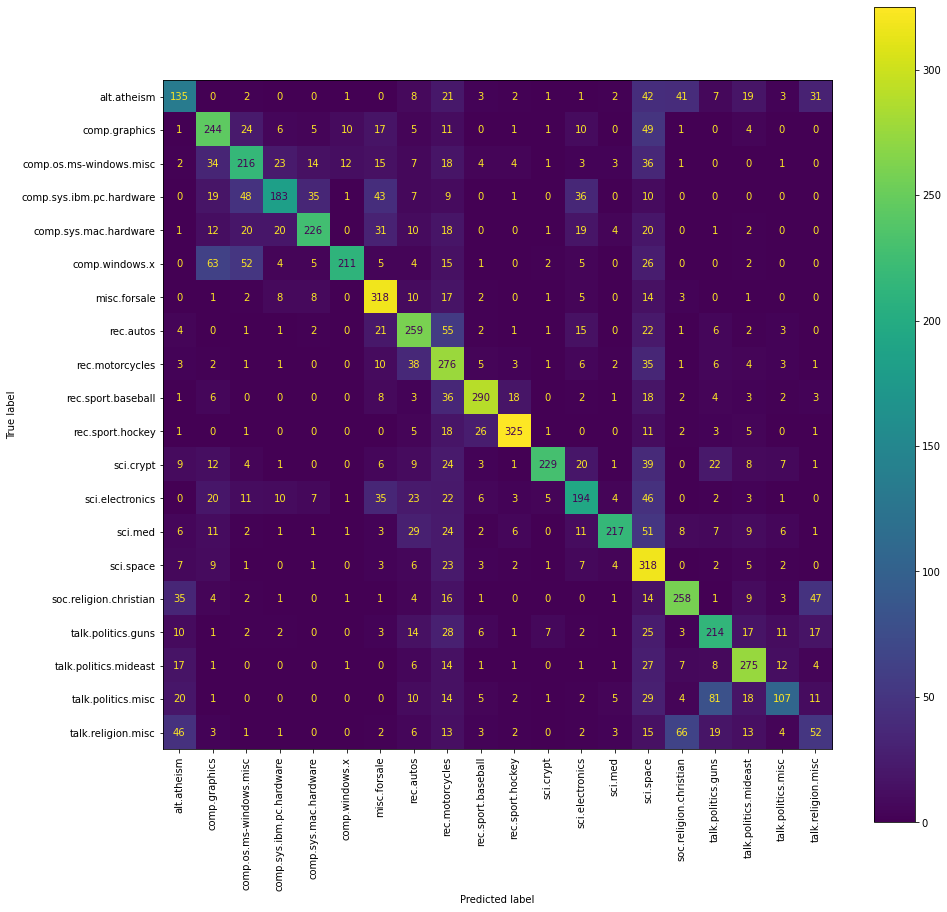

In [41]:
cm = confusion_matrix(test_corpus.target, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

In [42]:
print(classification_report(test_corpus.target, y_preds, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.45      0.42      0.44       319
           comp.graphics       0.55      0.63      0.59       389
 comp.os.ms-windows.misc       0.55      0.55      0.55       394
comp.sys.ibm.pc.hardware       0.70      0.47      0.56       392
   comp.sys.mac.hardware       0.74      0.59      0.66       385
          comp.windows.x       0.88      0.53      0.67       395
            misc.forsale       0.61      0.82      0.70       390
               rec.autos       0.56      0.65      0.60       396
         rec.motorcycles       0.41      0.69      0.52       398
      rec.sport.baseball       0.80      0.73      0.76       397
        rec.sport.hockey       0.87      0.81      0.84       399
               sci.crypt       0.91      0.58      0.71       396
         sci.electronics       0.57      0.49      0.53       393
                 sci.med       0.87      0.55      0.67       396
         

In [43]:
# We will look at a class with low precision and high recall
class_of_interest = test_corpus.target_names.index("rec.motorcycles")
class_of_interest

8

In [44]:
class_preds = np.where(y_preds == class_of_interest)[0]
print(class_preds)

[  42   50   54   70   71   87   88  101  110  127  147  160  173  183
  186  213  226  228  233  242  257  259  263  270  273  293  317  318
  320  343  356  360  371  388  405  413  428  431  463  472  502  505
  514  518  521  522  524  541  549  560  563  574  611  618  624  625
  633  646  662  667  670  680  693  723  724  745  749  755  798  821
  838  842  864  886  906  907  916  926  933  949  957  971  973  995
 1003 1004 1017 1029 1033 1041 1050 1069 1074 1078 1085 1168 1206 1217
 1237 1270 1290 1298 1324 1326 1327 1330 1345 1379 1388 1392 1393 1399
 1407 1412 1413 1440 1450 1456 1460 1499 1516 1538 1550 1568 1586 1588
 1594 1597 1599 1602 1613 1630 1631 1660 1680 1684 1685 1691 1695 1707
 1720 1721 1735 1736 1738 1749 1756 1795 1796 1797 1802 1803 1816 1827
 1836 1840 1878 1911 1923 1935 1938 1948 1953 1959 1982 2000 2002 2027
 2030 2034 2040 2051 2052 2055 2085 2095 2114 2125 2128 2157 2158 2165
 2171 2182 2197 2205 2208 2241 2242 2255 2265 2282 2284 2286 2298 2308
 2309 

In [45]:
misclassified_posts = np.nonzero(test_corpus.target != y_preds)[0]
print(misclassified_posts)

[   1    3    4 ... 7528 7529 7530]


In [46]:
misclassified_specific = class_preds[np.in1d(class_preds, misclassified_posts)]
print(misclassified_specific)

[  54   71   87  101  147  160  183  213  226  228  233  259  293  318
  320  343  388  413  463  502  514  521  522  541  563  611  618  624
  625  667  670  693  724  745  755  798  821  842  906  916  933  957
  973 1003 1004 1050 1074 1078 1168 1206 1217 1290 1298 1327 1379 1388
 1393 1399 1407 1412 1413 1450 1460 1499 1516 1538 1568 1588 1594 1597
 1599 1602 1613 1630 1680 1684 1685 1691 1695 1707 1720 1735 1736 1738
 1749 1756 1796 1797 1802 1803 1816 1827 1840 1923 1938 1948 1959 2000
 2002 2027 2034 2040 2051 2052 2055 2095 2125 2128 2157 2158 2171 2208
 2241 2242 2282 2286 2308 2309 2311 2313 2315 2367 2448 2459 2480 2493
 2504 2523 2525 2528 2564 2571 2599 2613 2615 2622 2629 2716 2723 2749
 2792 2803 2810 2831 2854 2886 2895 2896 2900 2921 2930 3059 3067 3074
 3075 3116 3138 3141 3151 3201 3209 3237 3261 3272 3318 3320 3338 3343
 3350 3355 3366 3382 3390 3450 3512 3542 3545 3556 3564 3607 3631 3633
 3683 3701 3711 3761 3780 3792 3800 3822 3823 3833 3844 3859 3894 3898
 3902 

In [47]:
for post_idx in misclassified_specific[:10]:
  print("Predicted class: {}".format(test_corpus.target_names[y_preds[post_idx]]))
  print("Actual class: {}".format(test_corpus.target_names[test_corpus.target[post_idx]]))
  print("Post: {}".format(preprocessed_test_corpus[post_idx]))
  print()

Predicted class: rec.motorcycles
Actual class: comp.graphics
Post: find

Predicted class: rec.motorcycles
Actual class: talk.politics.misc
Post: 

Predicted class: rec.motorcycles
Actual class: soc.religion.christian
Post: 

Predicted class: rec.motorcycles
Actual class: rec.sport.hockey
Post: 

Predicted class: rec.motorcycles
Actual class: sci.electronics
Post: 

Predicted class: rec.motorcycles
Actual class: sci.crypt
Post: 

Predicted class: rec.motorcycles
Actual class: alt.atheism
Post: incestuous

Predicted class: rec.motorcycles
Actual class: alt.atheism
Post: 

Predicted class: rec.motorcycles
Actual class: rec.autos
Post: 

Predicted class: rec.motorcycles
Actual class: comp.windows.x
Post: 



In [48]:
def filter_short_texts(text, min_len, split_char):
  tokens = text.split(split_char)
  return len(tokens) >= min_len

In [49]:
print('Number of training posts before filtering short texts: {}'.format(len(preprocessed_train_corpus)))

# Filter training corpus.
z = zip(preprocessed_train_corpus, train_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_train_corpus, train_corpus.target = zip(*f)

print('Number of training posts after filtering short texts: {}'.format(len(preprocessed_train_corpus)))

Number of training posts before filtering short texts: 11314
Number of training posts after filtering short texts: 10616


In [50]:
print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

z = zip(preprocessed_test_corpus, test_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_test_corpus, test_corpus.target = zip(*f)

print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

Number of testing posts before filtering short texts: 7532
Number of testing posts before filtering short texts: 7044


In [51]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [52]:
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))
y_train = keras.utils.to_categorical(train_labels)

X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

In [53]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

tf.random.set_seed(0)
initializer = tf.keras.initializers.HeNormal(seed=1)

model_next = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES, activation='softmax')
])

model_next.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_next.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[es_callback])

Epoch 1/15
71/71 [==============================] - 3s 32ms/step - loss: 2.0412 - accuracy: 0.4682 - val_loss: 1.1862 - val_accuracy: 0.7370
Epoch 2/15
71/71 [==============================] - 2s 30ms/step - loss: 0.7804 - accuracy: 0.8113 - val_loss: 0.8923 - val_accuracy: 0.7564
Epoch 3/15
71/71 [==============================] - 2s 30ms/step - loss: 0.3545 - accuracy: 0.9157 - val_loss: 0.8798 - val_accuracy: 0.7646
Epoch 4/15
71/71 [==============================] - 2s 28ms/step - loss: 0.1675 - accuracy: 0.9631 - val_loss: 0.9887 - val_accuracy: 0.7577


In [54]:
results = model_next.evaluate(X_test, y_test)

221/221 [==============================] - 1s 2ms/step - loss: 1.4823 - accuracy: 0.6651


221/221 [==============================] - 1s 2ms/step


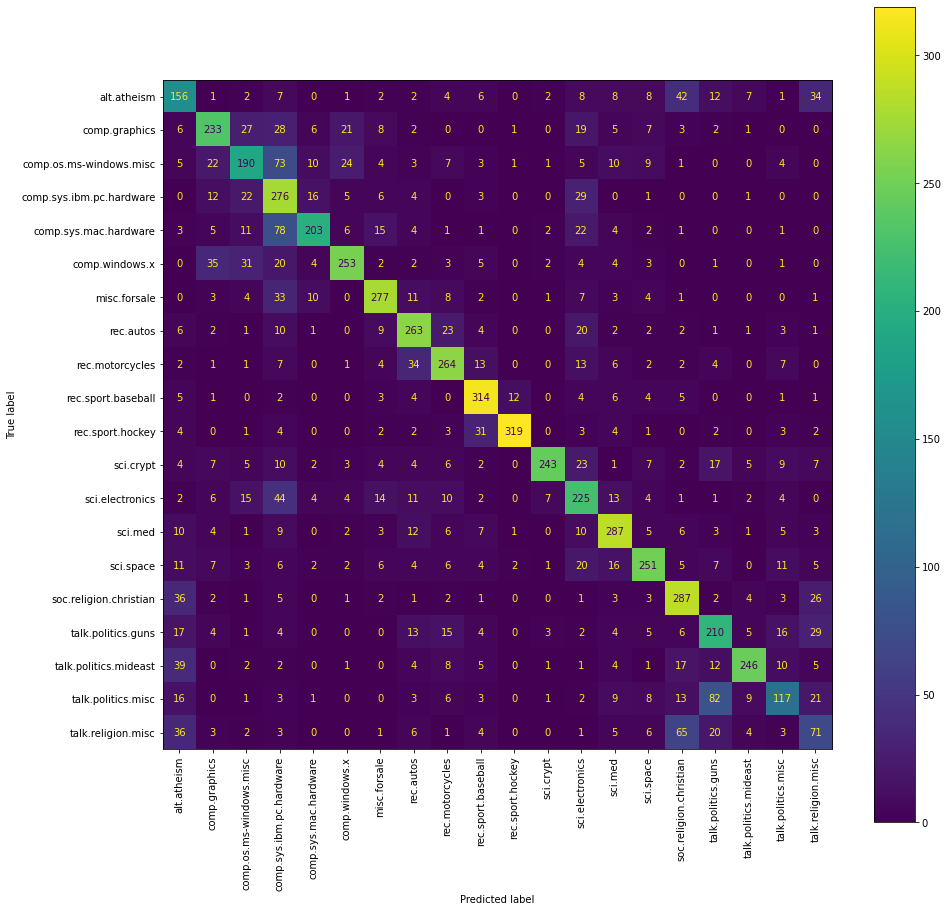

In [55]:
y_pred_probs = model_next.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Not normalizing this time. Just looking at raw numbers.
cm = confusion_matrix(test_corpus.target, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

In [56]:
print(classification_report(test_corpus.target, y_pred, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.51      0.47       303
           comp.graphics       0.67      0.63      0.65       369
 comp.os.ms-windows.misc       0.59      0.51      0.55       372
comp.sys.ibm.pc.hardware       0.44      0.74      0.55       375
   comp.sys.mac.hardware       0.78      0.57      0.66       359
          comp.windows.x       0.78      0.68      0.73       370
            misc.forsale       0.77      0.76      0.76       365
               rec.autos       0.68      0.75      0.71       351
         rec.motorcycles       0.71      0.73      0.72       361
      rec.sport.baseball       0.76      0.87      0.81       362
        rec.sport.hockey       0.95      0.84      0.89       381
               sci.crypt       0.92      0.67      0.78       361
         sci.electronics       0.54      0.61      0.57       369
                 sci.med       0.73      0.77      0.75       375
         

In [ ]:
target_names = test_corpus.target_names.copy()

def classify_post(post):
  vectorized_post = tokenizer.texts_to_matrix([('|').join(spacy_tokenizer(post))])
  probs = model_next.predict(vectorized_post)
  pred = np.argmax(probs, axis=1)[0]
  return target_names[pred], probs[0][pred]